# Plot partial charge difference at each atom between 2 sets of partial charges.

In [1]:
# comp chem imports
from openff.toolkit import Molecule
from openff.toolkit.utils import rdkit_wrapper
from openff.units import unit, Quantity
from openeye import oechem
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdFMCS
from openff.toolkit import Molecule

In [2]:
# data imports
import pandas as pd
import numpy as np
import json
import math

In [3]:
# plotting imports
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.gridspec as gridspec
from PIL import Image
import io
from io import BytesIO
from IPython.display import display

# Plotting functions

In [59]:
def round_UP_to_nearest_tenth(number):
    return math.ceil(number * 10) / 10

def get_color_scheme_dict(all_decimal_values):
    max_value = max(all_decimal_values)
    max_color_scheme = round_UP_to_nearest_tenth(max_value)
    
    all_decimal_values += [max_color_scheme]
    
    viridis_cmap = plt.get_cmap('Blues')
    
    norm = mcolors.Normalize(vmin=min(all_decimal_values), vmax=max(all_decimal_values))
    
    colors_rgb_dict = {
        round(value, 5) :(viridis_cmap(norm(value))[0], viridis_cmap(norm(value))[1], viridis_cmap(norm(value))[2]) for value in all_decimal_values
    }
    
    return colors_rgb_dict

def color_molecule(mol_orig, bonddq_diff, colors_rgb_dict, save_path=None):  
    mol = Chem.Mol(mol_orig)
    AllChem.Compute2DCoords(mol)
    mol_wo_H = Chem.RemoveHs(mol)

    mcs = rdFMCS.FindMCS([mol, mol_wo_H])
    patt = Chem.MolFromSmarts(mcs.smartsString)

    query_match = mol.GetSubstructMatch(patt)
    template_match = mol_wo_H.GetSubstructMatch(patt)

    index_convert = {query_match[i]: template_match[i] for i in range(len(query_match))}
    
    bond_ids = []
    colors = {}
    
    
    for i,b in enumerate(bonddq_diff):
        try:
            bond_ids.append(i)
            
            round_d = round(b, 5)
            
            colors[i] = colors_rgb_dict[round_d]
            
        except KeyError:
            print("err:", i)
            pass

    for atom in mol.GetAtoms():
        atom_idx = atom.GetIdx()
        atom.SetProp('atomNote', str(atom_idx)) 

    AllChem.Compute2DCoords(mol_wo_H)
    from rdkit.Chem.Draw import rdMolDraw2D
    
    highlight_radius = 0.5
    d = rdMolDraw2D.MolDraw2DCairo(800, 400)
    d.SetLineWidth(5)
    rdMolDraw2D.PrepareAndDrawMolecule(
        d,
        mol,
        highlightBonds=bond_ids,
        highlightBondColors=colors,
    )
        
    d.FinishDrawing()
    svg = d.GetDrawingText()
    svg_io = io.BytesIO(svg)  # Use io.BytesIO for bytes data
    img = Image.open(svg_io)
    img.save(save_path, "PNG")

    display(img)

# Variables to edit

In [60]:
molname = 'lig_206'
# the name of the molecule you want to plot the qdifference of

imgname = f'../examples/{molname}_bonddq_diff_w_legend.png'
# path to save the image to

csvfile = "../examples/openeye_am1bcc_lig_206_dq.csv"
# csv file containing atomic partial charges for each conformer

sdffile = '../molecules/PLB_simulation_all.sdf'
# sdf file containing the molecule you want to depict

conf1_idx = 0
conf2_idx = 1
# the conformer indices of the conformers atomic partial charges you'd like to compare

OFFSET = 5

### Load in the molecules in the CSV as rdkit molecules in a dictionary keyed by their names

In [61]:
all_sim_mols = {mol.GetProp('_Name'): Chem.AddHs(mol) for mol in Chem.SDMolSupplier(sdffile)}

### Calculate the qdiff at each atom for the conformers of interest

In [62]:
df = pd.read_csv(csvfile)
bonddq_conf1 = np.array(df.iloc[:, conf1_idx+OFFSET])
bonddq_conf2 = np.array(df.iloc[:, conf2_idx+OFFSET])
bonddq_diff = np.abs(bonddq_conf1 - bonddq_conf2)

### Generate a color scheme for based on the decimal values you have
* lighter blues = smaller difference
* darker blues = larger difference

In [64]:
colors_rgb_dict = get_color_scheme_dict(bonddq_diff)

### Create the 2D molecule image where each atom is colored by the degree of atomic partial charge difference between the 2 conformers

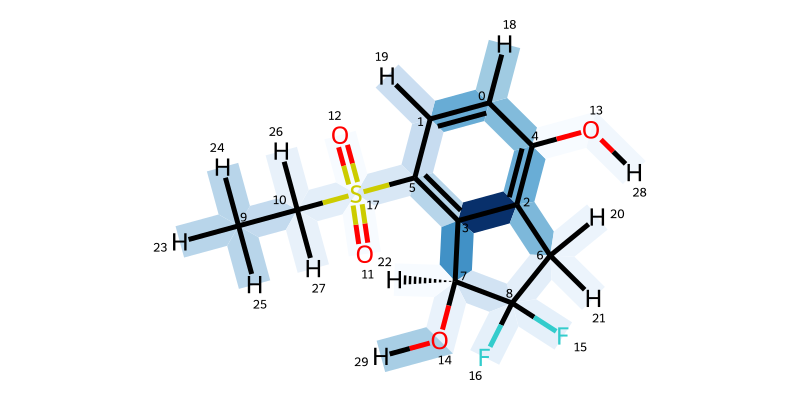

In [65]:
color_molecule(all_sim_mols[molname], bonddq_diff, colors_rgb_dict, save_path=imgname) 

### Create the legend for the partial charge difference based on color

/var/folders/sy/34y0lz1s1f7c_490gq61gtv80000gp/T/ipykernel_25961/1868960682.py:20: UserWarning: Adding colorbar to a different Figure <Figure size 1000x1000 with 2 Axes> than <Figure size 500x800 with 2 Axes> which fig.colorbar is called on.
  cb = fig_colorbar.colorbar(cax, ax=ax_colorbar)


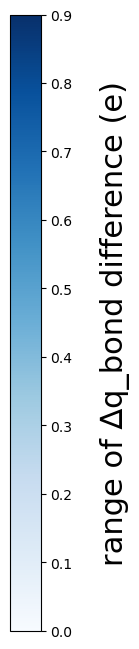

In [66]:
x = np.linspace(0, round(round_UP_to_nearest_tenth(max(bonddq_diff)), 1) + 0.1)
x[-1] = round(x[-1], 1)
y = np.sin(x)

# Create a figure and subplot
f,ax = plt.subplots(figsize=(10, 10))

# Plot the data with the Viridis colormap
cax = ax.scatter(x, y, c=x, cmap='Blues')

# Add a colorbar
cbar = f.colorbar(cax, ax=ax, orientation='vertical')
ticks = list(np.arange(0, round(round_UP_to_nearest_tenth(max(bonddq_diff)),1) + 0.1, 0.1))
ticks[-1] = round(ticks[-1], 1)
cbar.set_ticks(ticks)
plt.close()

# Remove axes and save only the legend
fig_colorbar, ax_colorbar = plt.subplots(figsize=(5, 8))  # Adjust the size of the color bar figure
cb = fig_colorbar.colorbar(cax, ax=ax_colorbar)

cb.ax.text(1.4, 0.5, 'range of ∆q_bond difference (e)', fontsize=22, rotation=90, 
                 va='center', ha='center', transform=ax_colorbar.transAxes)
ax_colorbar.remove()
fig_colorbar.savefig('atmwise_legend.png', bbox_inches='tight', pad_inches=0, dpi=100)

### Create an image that combines both the 2D image of the molecule and the charge difference legend

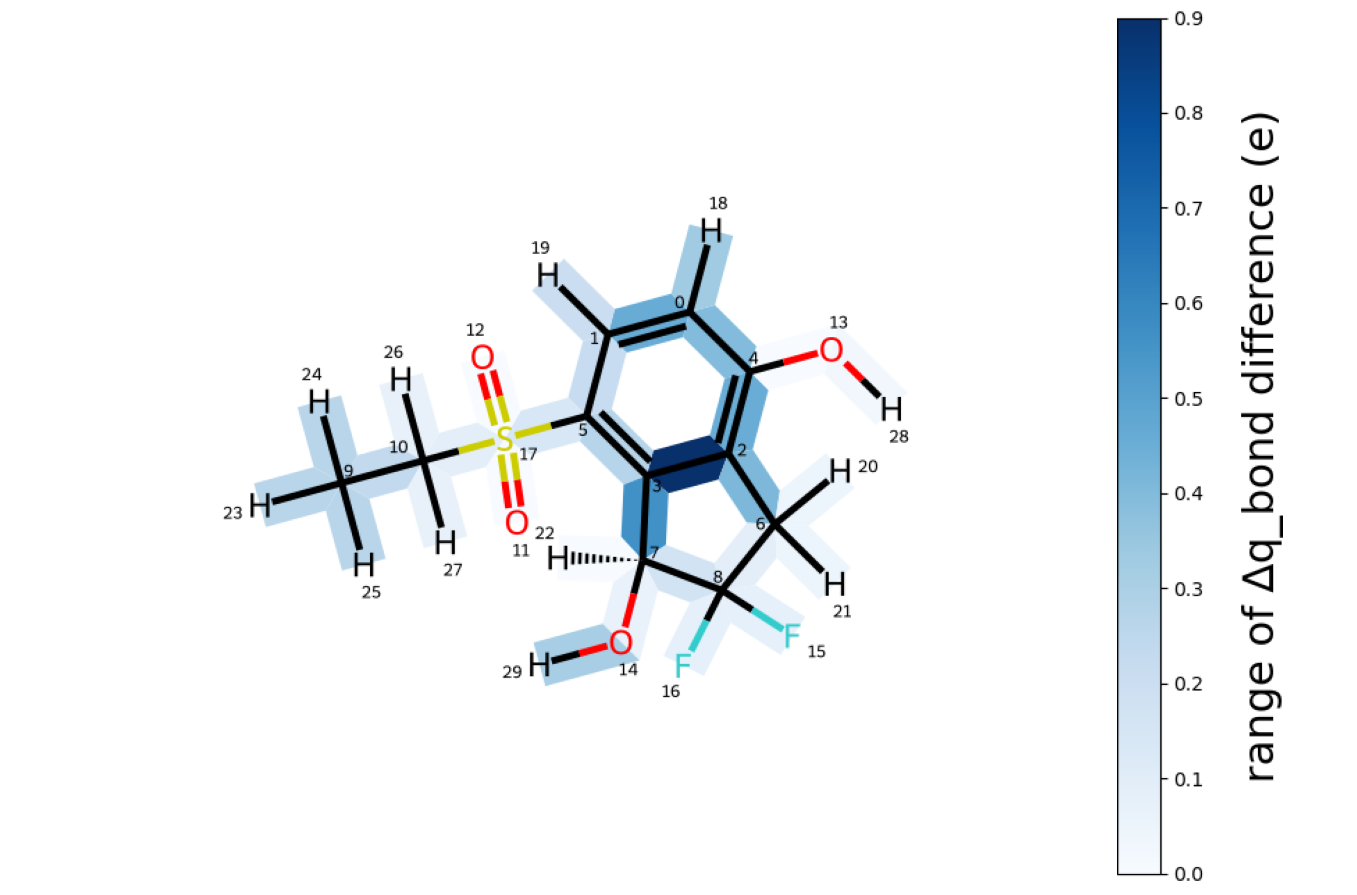

In [67]:
f = plt.figure(figsize=[15,10])

# Create a GridSpec with 1 row and 2 columns
gs = gridspec.GridSpec(1, 2, width_ratios=[80,20])

# Create the subplots
ax0 = f.add_subplot(gs[0])
ax1 = f.add_subplot(gs[1])

img = np.asarray(Image.open("atmwise_legend.png"))
imagebox = OffsetImage(img)

xy = (0.3, 0.5)

# Create an annotation box for the image
ab = AnnotationBbox(imagebox, xy, xycoords='axes fraction', frameon=False, pad=0)


# Add the image to the subplot
ax1.add_artist(ab)
#.imshow(img)
ax1.axis('off')
ax1.set_aspect('auto')

img = np.asarray(Image.open(imgname))
imagebox = OffsetImage(img)

# Create an annotation box for the image
xy = (0.45, 0.5)
ab = AnnotationBbox(imagebox, xy, xycoords='axes fraction', frameon=False, pad=0)


# Add the image to the subplot
ax0.add_artist(ab)
ax0.axis('off')
ax0.set_aspect('auto')

plt.savefig(imgname, dpi=500, bbox_inches='tight', pad_inches=0)